# Identificación 3D con PointNet 



Una __nube de puntos__ está definida por una colección de puntos __(x,y,z)__ que define una escena. A ellos se puede unir otros atributos relacionados, como puede ser el color __(r,g,b)__ u otros parámetros del espectro electromagnético que devuelve el sensor utilizado para capturar la información de la misma.

Cuando se dispone de información que __estructura__ los puntos, como puede ser una triangulación, una envolvente convexa o una forma alfa basada en vértices o caras, se habla de __malla__.

Alguna de las __operaciones__ más importantes que se pueden aplicar a las nubes de puntos son:

- __Segmentación__: Dividir la imagen en regiones de interés, identificando cada una de las partes. 
- __Clasificación__: de la nube en una determinada categoría.
- __Detección__: es una extensión de la clasificación en la que se reconocen objetos de la escena y se localizan mediante un cuadro limitador.

Los primeros enfoques del procesado de nubes de puntos se basaban en el uso de cuadrículas y su convolución. Hay primero un __procesamiento__ que se encarga de convertir las nubes de puntos en grids con un número de __vóxeles__ fijos ({cite:p}`wu20153d`). Siendo un vóxel un pixel 3D. Al grid 3D se aplica procesos de __convolución 3D__ como los vistos en el tratamiento de imagenes 2D y unas capas de clasificación de redes densas. _El rendimiento de los métodos basados en vóxeles es bueno, pero tienen un alto consumo de memoria debido a la dispersión de los vóxeles. La dispersión provoca pérdidas de cálculo a la hora de convolucionar en regiones no ocupadas, sumándose a las pérdidas producidas por la representación volumétrica_.

Otros métodos se basan en aplicar convoluciones 2D a __multiples vistas bidimensionales__ ({cite:p}`su2015multi`) generadas con proyecciones 2D desde diferentes posiciones giradas. _Estas redes muestran mejores resultados que los métodos basados en vóxeles. Además, no arrastran las pérdidas producidas en la representación volumétrica_.

__CNN espectrales sobre mallas__ que está restringidos a mallas tubulares de objetos orgánicos ({cite:p}`bruna2013spectral`)

__PointNet__ ({cite:p}`qi2017pointnet`) consume nubes de puntos simples __(x,y,z)__ lo que evita las irregularidades combinatorias y las complejidades de las mallas. Respeta que la nube de puntos es invariante a las permutaciones de sus elementos y considera otras invariancias de los movimientos rígidos.

__PointNet__ toma como entrada una nube de puntos y devuelve su clase para el conjunto de la nube o clase por punto generando una segmentación. En el formato básico la entrada son coordenadas __(x,y,z)__, aunque se pueden añadir dimensiones calculando las normales y otras características locales o globales.

Una de las claves de la aproximación de __PointNet__ es el uso de una única función simétrica de agrupación (__max pooling__). La red aprende una serie de criterios que seleccionan puntos de interés de la nube y codifica la razón de su selección. Finaliza con una __red densa__ que agrega la clase global o para predecir la clase por punto.

__Point Features__ : las características de los puntos a menudo codifican ciertas propiedades estadísticas de los puntos y están diseñados para ser invariantes a ciertas transformaciones, intrínsecas o extrínsecas.

La arquitectura __PointNet__ se inspira en las propiedades de un conjunto de puntos en $\Re^n$:

- __Desordenados__: implica que una nube de $N$ puntos se debe tratar con una red __invariante__ a las $N!$ __permutaciones__.
- __Interacción entre puntos__: debe ser capaz de capturar estructuras locales desde puntos cercanos, y sus interacciones combinatorias.
- __Invariante ante transformaciones__: las rotaciones y translaciones de puntos no deben modificar la categoria asignada.

La estrategia usada por __PointNet__ para ser invariante a las permutaciones de la nube de entrada es usar una __función simétrica__ simple para agregar la información de cada punto. La solución sencilla de ordenar no funciona en un espacio de alta dimensión. Tampoco sirven las redes neuronales recurrentes (RNN), usadas para modelar series temporales, y que son invariantes a bloques de pequeña longitud, como docenas. La función simétrica se aproxima con:

$$f(\{x_1, ..., x_n\})\approx g(h(x_1),...,h(x_n))$$

Donde $h :  \Re^N \rightarrow \Re^K$ y $g :  \Re^K \times ... \times \Re^K \rightarrow \Re $

PointNet aproxima __h__ con un perceptron multicapa (__MLP__) y __g__ por una composición de una función de una variable y una función de agrupación máxima (__max pooling__). A través de una __colección de h's__, se puede aprender un número de __f's__ para capturar diferentes propiedades del conjunto.

<img src="images/pointnet.jpg" width="700px">

La salida de la sección anterior forma un vector $[f_1, . . . , f_K]$, que es un __distintivo__ global del conjunto de __entrada__. Se podría tratar de clasificar con un perceptron multicapa, sin embargo la segmentación requiere de una combinación de conocimientos locales y globales.

Después de calcular el vector de características de la nube de puntos global (__global feature__), se concatenan las características globales con cada una de las características de puntos. Luego, se extraen nuevas características por punto en función de las características de punto combinadas; esta vez, la característica por punto _"conoce"_ información local y global (__point features__).

El __etiquetado semántico__ de una nube de puntos tiene que ser __invariante a transformaciones geométricas__. Para hacer esto __PointNet__ predice una matriz de transformación afin usando una mini-red que se denomina __T-net__ en el gráfico anterior y que aparece implementada en el código de este cuaderno en la clase __Tnet(nn.Module)__. Esta matriz se aplica directamente a las coordenadas de la nube de puntos de entrada. __T-net__ está compuesta por módulos de extracción de características de los puntos, agrupación máxima y capas totalmente conectadas.

Esta idea se extiende al espacio de características (__feature transform__ en el esquema anterior), pero la matriz de transformación tiene una dimensión considerablemente superior (__64 vs 3__), lo que aumenta en idéntica medida la dificultad de optimización.

Por tanto, se agrega un término de regularización a la función de pérdida de entrenamiento softmax. Y se ajusta la matriz de transformación de características para que esté cerca de la matriz ortogonal:

$$L_{reg}=\| I - AA^T \| ^2_F$$

Donde $A$ es la matriz de alineación de características (__64x64__) predicha por __T-net__ en el paso __feature transform__.

__Qi__ demuestra que la función __f(S)__ se pude aproximar con $\gamma(\displaystyle\max_{x_i \in S}(h(x_i)))$, donde __S__ es la nube y __max__ en un agrupador de máximo o max pooling.

La arquitectura utilizada para programar __PointNet__ en el presente cuaderno es __Pytorch__.

In [26]:
import os
import numpy as np
import itertools
import math, random
random.seed = 42

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from pathlib import Path
import scipy.spatial.distance
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

__En función de los indicadores booleanos siguientes es posible parametrizar el funcionamiento del cuaderno. Así activando a True cada uno de ellos__:

- __googleColaboratory__: el cuaderno trabaja en un entorno Google Colaboratory.
- __entrenamiento__: no accede al fichero pre-entrenado y realiza un nuevo entrenamiento. __Es recomendable realizarlo en Colaboratory con entorno de ejecución CPU o TPU__.
- __downloadModel__: descarga de un alojamiento en línea el archivo __ModelNet10.zip__ con un set de entrenamiento y validación de nubes con 10 etiquetas posibles.
- __unzipModel__: descomprime el fichero zip anterior sobre un conjunto de subdirectorios.
- __staticPlot__: tiene sentido su uso a True para generar el HTML estático de JupyterBook que no soporta los gráficos dinámicos construidos con la librería __plotly__, en local poner a False.

In [27]:
googleColaboratory=False
entrenamiento=False
downloadModel=False
unzipModel=False
staticPlot=True

## Carga de datos

In [28]:
if googleColaboratory:
  from google.colab import drive
  drive.mount('/content/drive/')

In [29]:
#pip install wget

In [30]:
if not downloadModel:
    print("No activa la descarga del modelo")
elif googleColaboratory:
    !wget http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
else:
    !python -m wget http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip

No activa la descarga del modelo


In [31]:
if not unzipModel:
    print("No activo el desenpaquetado del modelo")
elif googleColaboratory:
    !unzip -q ModelNet10.zip
else:
    !python -m zipfile -e ModelNet10.zip "./data/"

No activo el desenpaquetado del modelo


In [32]:
path = Path("ModelNet10") if googleColaboratory else Path("./data/ModelNet10")
print(path.absolute())

folders = [dir for dir in sorted(os.listdir(path)) if os.path.isdir(path/dir)]
classes = {folder: i for i, folder in enumerate(folders)};
classes

C:\Users\valer_z\ownCloud - VALERIANO MENDEZ FUENTES@drive.upm.es\AA\jupyterbook\bookIAA\data\ModelNet10


{'bathtub': 0,
 'bed': 1,
 'chair': 2,
 'desk': 3,
 'dresser': 4,
 'monitor': 5,
 'night_stand': 6,
 'sofa': 7,
 'table': 8,
 'toilet': 9}

## Utilidades de visualización

In [33]:
def read_off(file):
    off_header = file.readline().strip()
    if 'OFF' == off_header:
        n_verts, n_faces, __ = tuple([int(s) for s in file.readline().strip().split(' ')])
    else:
        n_verts, n_faces, __ = tuple([int(s) for s in off_header[3:].split(' ')])
    verts = [[float(s) for s in file.readline().strip().split(' ')] for i_vert in range(n_verts)]
    faces = [[int(s) for s in file.readline().strip().split(' ')][1:] for i_face in range(n_faces)]
    return verts, faces


def visualize_rotate(data, xSize=750, ySize=500):
    
    x_eye, y_eye, z_eye = 1.25, 1.25, 0.8
    frames=[]

    def rotate_z(x, y, z, theta):
        w = x+1j*y
        return np.real(np.exp(1j*theta)*w), np.imag(np.exp(1j*theta)*w), z

    for t in np.arange(0, 10.26, 0.1):
        xe, ye, ze = rotate_z(x_eye, y_eye, z_eye, -t)
        frames.append(dict(layout=dict(scene=dict(camera=dict(eye=dict(x=xe, y=ye, z=ze))))))
    fig = go.Figure(data=data,
        layout=go.Layout(
            updatemenus=[dict(type='buttons',
                showactive=False,
                y=1,
                x=0.8,
                xanchor='left',
                yanchor='bottom',
                pad=dict(t=45, r=10),
                buttons=[dict(label='Play',
                    method='animate',
                    args=[None, dict(frame=dict(duration=50, redraw=True),
                        transition=dict(duration=0),
                        fromcurrent=True,
                        mode='immediate'
                        )]
                    )
                ])]
        ),
        frames=frames
    )

    fig.update_layout(autosize=False, width=xSize, height=ySize)
    return fig


def pcshow(xs,ys,zs, xSize=750, ySize=500):
    if staticPlot:
        staticPlot(xs,ys,zs)
        return
        
    data=[go.Scatter3d(x=xs, y=ys, z=zs,
                                   mode='markers')]
    fig = visualize_rotate(data, xSize, ySize)
    fig.update_traces(marker=dict(size=2,
                      line=dict(width=2,
                      color='DarkSlateGrey')),
                      selector=dict(mode='markers'))
    fig.show()

def staticPlot(xs,ys,zs):
    fig = plt.figure(figsize=(12,9))
    ax = fig.add_subplot(projection='3d')
    ax.scatter(xs, ys, zs, marker='o')
    plt.show()

def staticSurface(xs,ys,zs):
    fig = plt.figure(figsize=(12,9))
    ax = plt.axes(projection='3d')
    ax.plot_trisurf(xs, ys, zs, cmap='viridis', edgecolor='none');

### Se carga un fichero de ejemplo y se visualiza

El fichero de extensión off es de texto con la siguiente estructura:
- Primera línea de cabecera con la etiqueta OFF.
- Segunda línea de cabecera con 3 contadores de detalle: nº de vértices (NV), nº de caras (NC) y un tercero sin usar
- Una lista de NV números x,y,z con las coordenadas de cada vértice
- Una lista de NC caras con números enteros que indican: primero el número de vértices que forman la cara (3 si es un triángulo), y los valores enteros de la posición del vértice en la anterior lista de vértices que forman la cara

La función __read_off__ obtiene la lista de vértices y de caras.

La visualización se realiza con métodos de la librería __plotly.graph_objects__ que permite generar una animación tridimensional.

- 

In [34]:
with open(path/"bed/test/bed_0516.off", 'r') as f:
    verts, faces = read_off(f)
    
i,j,k = np.array(faces).T
x,y,z = np.array(verts).T
"Número de vértices=" , len(x)

('Número de vértices=', 15069)

El método __plotly.graph_objects.Mesh3d__ genera una __malla__ para pasar a __visualize_rotate__ a partir de la lista de coordenadas (x,y,z) de los vértices y las posiciones (i,j,k) de los 3 vértices de cada uno de los triángulos obtenidos en una triangulación de __Delaunay__, en una envovelvente convexa (__convex-hull__) o una forma alfa (__alpha-shape__).

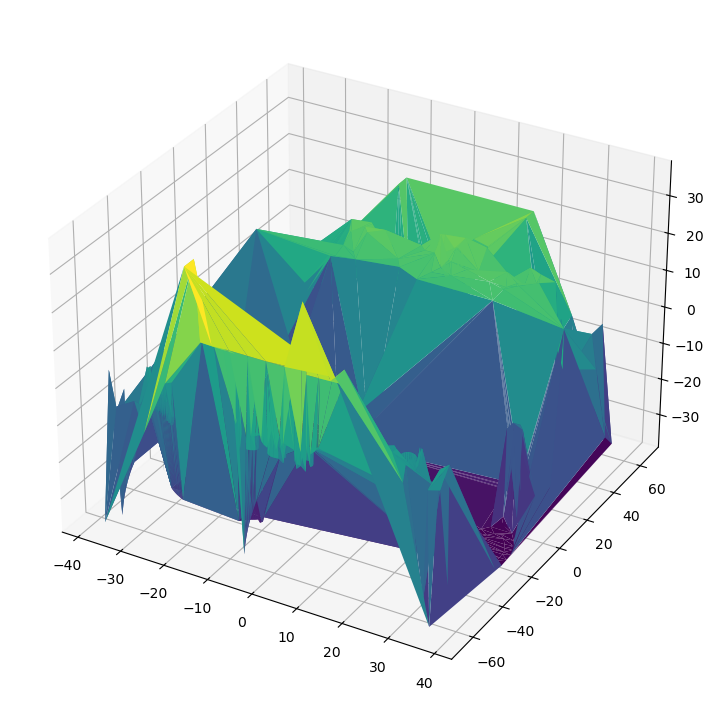

In [35]:
if staticPlot:
    staticSurface(x,y,z)
else:
    visualize_rotate([go.Mesh3d(x=x, y=y, z=z, color='lightpink', opacity=0.50, i=i,j=j,k=k)]).show()

__Por contra__ si se utiliza __plotly.graph_objects.Scatter3d__ se está generando una nube desestructrara utilizando unicamente las coordenadas __(x,y,z)__ de los __vertices__.

La función __pcshow__ dibuja la animación de la nube desestructarada pero usando un tamaño de punto más pequeño.

La animación permite, pulsando el botón __Play__, mostrar vistas con diferentes giros y al __pasar el ratón se visualizan las coordenadas__ de los vértices.

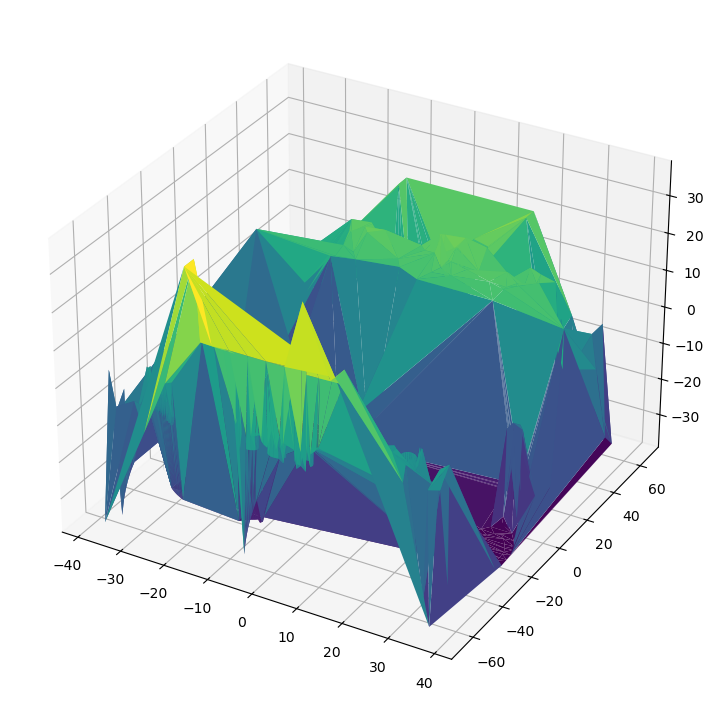

In [36]:
if staticPlot:
    staticSurface(x,y,z)
else:
    visualize_rotate([go.Scatter3d(x=x, y=y, z=z, mode='markers')]).show()

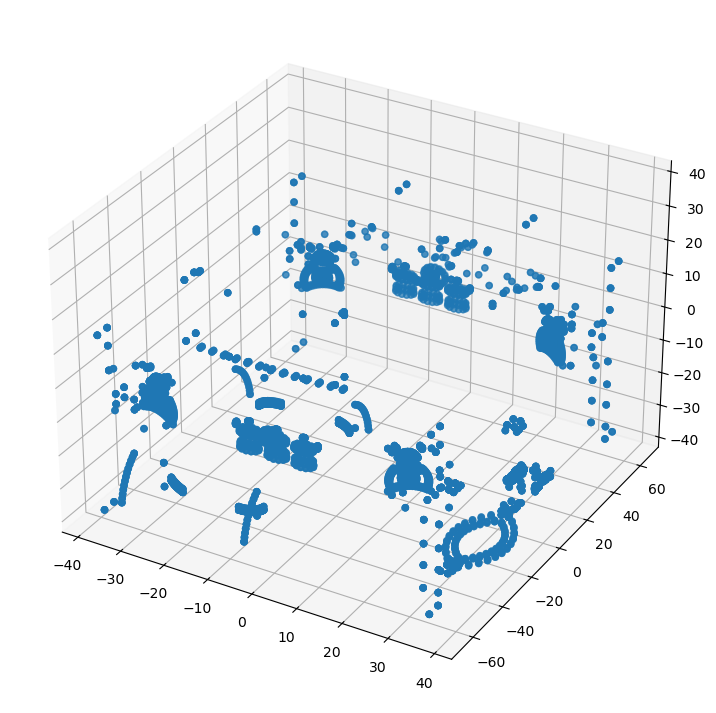

In [37]:
pcshow(x,y,z)

## Creación de Datasets y Dataloaders

### Clases que son necesarias definir para crear el Dataset a partir de los ficheros



La clase __PointSampler__ selecciona una lista de __K__ puntos elegidos aleatoriamente con __Radom.choice()__.

El método choice() devuelve una lista con __K__ elementos seleccionado al azar de la __secuencia especificada__. La secuencia puede ser una cadena, un rango, una lista, una tupla o cualquier otro tipo de secuencia. Cada elemento de la secuencia puede llevar un peso (parámetro __weights__). En PointSampler se pasa como secuencia la lista de caras y como peso de cada cara su área.

De las caras que selecciona choice() se calcula el baricentro del triángulo. Y finalmente se devuelve como salida de PointSampler un array numpy de longitud __K__ (_output_size_) con las 3 coordenadas de la lista de baricentros. Quiere decir que __PointSampler__ devuelve una lista de puntos __(x,y,z)__ que se corresponde con una __nube desestructurada__.


In [38]:
class PointSampler(object):
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size
    
    def triangle_area(self, pt1, pt2, pt3):
        side_a = np.linalg.norm(pt1 - pt2)
        side_b = np.linalg.norm(pt2 - pt3)
        side_c = np.linalg.norm(pt3 - pt1)
        s = 0.5 * ( side_a + side_b + side_c)
        return max(s * (s - side_a) * (s - side_b) * (s - side_c), 0)**0.5

    def sample_point(self, pt1, pt2, pt3):
        # barycentric coordinates on a triangle
        # https://mathworld.wolfram.com/BarycentricCoordinates.html
        s, t = sorted([random.random(), random.random()])
        f = lambda i: s * pt1[i] + (t-s)*pt2[i] + (1-t)*pt3[i]
        return (f(0), f(1), f(2))
        
    
    def __call__(self, mesh):
        verts, faces = mesh
        verts = np.array(verts)
        areas = np.zeros((len(faces)))

        for i in range(len(areas)):
            areas[i] = (self.triangle_area(verts[faces[i][0]],
                                           verts[faces[i][1]],
                                           verts[faces[i][2]]))
            
        sampled_faces = (random.choices(faces, 
                                      weights=areas,
                                      cum_weights=None,
                                      k=self.output_size))
        
        sampled_points = np.zeros((self.output_size, 3))

        for i in range(len(sampled_faces)):
            sampled_points[i] = (self.sample_point(verts[sampled_faces[i][0]],
                                                   verts[sampled_faces[i][1]],
                                                   verts[sampled_faces[i][2]]))
        
        return sampled_points

La clase __Normalize__ le resta a la nube de puntos (x,y,z) su media y los divide por la norma máxima.

La clase __ToTensor__ convierte un array numpy en un Tensor para poder pasar los datos a pyTorch.

El método __default_transforms__ hace una composición de 3 operaciones en cadena:
- Obtener un array numpy de 1024 puntos a partir de una lista de vértices y caras obtenidas en un fichero OFF.
- Se normaliza el array
- Se convierte el array en un Tensor de dos dimensiones con una nube normalizada de (1024, 3)

A PointNet se le pasan nubes de tamaño (1024,3). En el caso que se quisiera considerar el color en el modelo se añadirian 3 canales de entrada y se pasaría a PointNet tensores bidimensionales de (1024,6).

In [39]:
class Normalize(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2
        
        norm_pointcloud = pointcloud - np.mean(pointcloud, axis=0) 
        norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1))

        return  norm_pointcloud

In [40]:
class ToTensor(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        return torch.from_numpy(pointcloud)

In [41]:
def default_transforms():
    return transforms.Compose([
                                PointSampler(1024),
                                Normalize(),
                                ToTensor()
                              ])

In [42]:
tensorCloud = ToTensor()(Normalize()(PointSampler(1024)((verts, faces))))
tensorCloud.shape

torch.Size([1024, 3])

In [43]:
tensorCloud = default_transforms()((verts, faces))
tensorCloud.shape

torch.Size([1024, 3])

La clase __RandRotation_z__ genera una rotación aleatoria sobre el eje __Z__ utilizando un angulo $\theta$, que es un ratio $r$ aleatorio de $2\pi$. Luego $\theta=2r\pi$, con $r \in [0,1]$ obtenido con __random.random()__.

La clase __RandomNoise__ genera una nube de __ruido blanco__ de igual dimensión que la dada con puntos cuyas coordenadas son valores aleatorios obtenidos en una distribución normal de media $\mu=0$ y desviación típica $\sigma=0.02$.

In [44]:
class RandRotation_z(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        theta = random.random() * 2. * math.pi
        rot_matrix = np.array([[ math.cos(theta), -math.sin(theta),    0],
                               [ math.sin(theta),  math.cos(theta),    0],
                               [0,                             0,      1]])
        
        rot_pointcloud = rot_matrix.dot(pointcloud.T).T
        return  rot_pointcloud
    
class RandomNoise(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        noise = np.random.normal(0, 0.02, (pointcloud.shape))
    
        noisy_pointcloud = pointcloud + noise
        return  noisy_pointcloud

La clase __PointCloudData__ está preparada para leer los archivos __OFF__ del modelo de entrenamiento __ModelNet10__ o __ModelNet40__. El conjunto __ModelNet__ está formado por 10 o 40 categorias de objetos. Cada categoria es un directorio. Por ejemplo el directorio __bed__ identifica los objetos cama. Dentro de cada categoría hay un subdirectorio que identifica los conjuntos __train__ de entrenamiento y __test__ de validación.

Al constructor de PointCloudData se le pasan los parámetros:
- __root_dir__ : con la ruta del directorio hasta cada una de las categorías.
- __folder__ : la carpeta del conjunto a recuperar. Por defecto: _train_.
- __transform__ : la operación de transformación a aplicar a la nube puntos recuperada de cada fichero. Por defecto: _default_transforms_ 

El resultado es una lista y en cada elemento un dictionary con un atributo __'pointcloud'__ con la nube de puntos y __'category'__ con el nombre de la clase.

In [45]:
class PointCloudData(Dataset):
    def __init__(self, root_dir, valid=False, folder="train", transform=default_transforms()):
        self.root_dir = root_dir
        folders = [dir for dir in sorted(os.listdir(root_dir)) if os.path.isdir(root_dir/dir)]
        self.classes = {folder: i for i, folder in enumerate(folders)}
        self.transforms = transform if not valid else default_transforms()
        self.valid = valid
        self.files = []
        for category in self.classes.keys():
            new_dir = root_dir/Path(category)/folder
            for file in os.listdir(new_dir):
                if file.endswith('.off'):
                    sample = {}
                    sample['pcd_path'] = new_dir/file
                    sample['category'] = category
                    self.files.append(sample)

    def __len__(self):
        return len(self.files)

    def __preproc__(self, file):
        verts, faces = read_off(file)
        if self.transforms:
            pointcloud = self.transforms((verts, faces))
        return pointcloud

    def __getitem__(self, idx):
        pcd_path = self.files[idx]['pcd_path']
        category = self.files[idx]['category']
        with open(pcd_path, 'r') as f:
            pointcloud = self.__preproc__(f)
        return {'pointcloud': pointcloud, 
                'category': self.classes[category]}

En el __entrenamiento de PointNet__ se utiliza una transformación que concatena a la __selección de los 1024 puntos__ y la __normalización__, una __rotación aleatoria en Z__ y __ruido blanco__ para dotar de mayor grado de varianza.

In [46]:
train_transforms = transforms.Compose([
                    PointSampler(1024),
                    Normalize(),
                    RandRotation_z(),
                    RandomNoise(),
                    ToTensor()
                    ])

### Creación de los DataSets

Utilizando la clase __PointCloudData__ se construye el DataSet tanto de entrenamiento, como de validación.

In [47]:
if entrenamiento:
    train_ds = PointCloudData(path, transform=train_transforms)
valid_ds = PointCloudData(path, valid=True, folder='test', transform=train_transforms)

In [49]:
if entrenamiento:
    inv_classes = {i: cat for cat, i in train_ds.classes.items()};
    inv_classes
else:
    inv_classes = {i: cat for cat, i in valid_ds.classes.items()};
    inv_classes    

In [50]:
if entrenamiento:
    print('Train dataset size: ', len(train_ds))
    print('Number of classes: ', len(train_ds.classes))
    print('Sample pointcloud shape: ', train_ds[0]['pointcloud'].size())
    print('Class: ', inv_classes[train_ds[0]['category']])
else:
    print('Valid dataset size: ', len(valid_ds))
    print('Number of classes: ', len(valid_ds.classes))
    print('Sample pointcloud shape: ', valid_ds[0]['pointcloud'].size())
    print('Class: ', inv_classes[valid_ds[0]['category']])
    

Valid dataset size:  908
Number of classes:  10
Sample pointcloud shape:  torch.Size([1024, 3])
Class:  bathtub


### Creación de los DataLoader.

A partir del anterior Dataset se construye el DataLoader con la librería __torch.utils.data.DataLoader__

https://pytorch.org/docs/stable/data.html


In [51]:
if entrenamiento:
    trainloader = DataLoader(dataset=train_ds, batch_size=32, shuffle=True)
testloader = DataLoader(dataset=valid_ds, batch_size=64)

## Definición del Modelo

La __arquitectura PoinNet__ propuesta por Qi et al. en 2017 de la universidad de Standford (http://stanford.edu/~rqi/pointnet/) a partir de nubes de puntos 3D no estructurada aprende características de los puntos globales y locales permitiendo el reconocimiento o clasificación del objeto representado en la nube.

PointNet consume sólo una __nube de puntos sin procesar o desestructurada__, definida únicamente por las coordenadas $(x,y,z)$ sin información de la conectividad que pueden aportar la existencia de caras o vértices de una malla asociada a dichos puntos. Adicionalmente a los 3 canales con las coordenadas $(x,y,z)$ se le pueden pasar __nuevos canales con el color__ $(r,g,b)$ o __diferentes canales electromagnéticos__ que obtengan los __sensores__ empleados en la captura de la información, como pueden ser diferentes valores de infrarrojos.

<img src="images/pointnet.jpg" width="700px">

La red selecciona puntos interesantes de la nube y codifican el motivo de su selección. Las capas finales, totalmente conectadas, asocia la nube con un descriptor global (clasificación) o una etiqueta por punto (segmentación).

Al ser el formato de entrada muy sencillo, puntos independientes, es fácil aplicar transformaciones que canonizan los datos y mejoran su clasificación.

El proceso está resuelto en el método __forward__ de la clase __PointNet__ que realiza una llamada a la clase __Transform()__ seguido de dos bloques totalmente conectados, donde aparecen capas de perceptron multicapa (función __nn.Linear__ de pyTorch), de normalización (función __nn.BatchNorma__), ReLu (función __nn.Relu__) y dropout (función __nn.dropout__).

La clase __Transform()__ consta de 2 bloques resueltos con una función común __Tnet()__.

El primer bloque es lo que se denomina __input transform__ en el esquema. Se aplica al tensor __nx3__ (siendo n la dimensión de la nube de puntos). El proceso __Tnet()__ que se aplica aquí está formado por:
- 3 capas de convolución con un kernel de dimensión y salto 1. Estas 3 convoluciones llevan las dimensiones de los tensores a 64, 128 y 1024. Tras realizar la convolución se aplica una normalización y una activación ReLU.
- Una capa de agrupación o max pooling
- 2 capas densas o totalmente conectadas, con normalización y ReLU, que lleva la dimensión a 512 y 256
- 1 capa densa que lleva la dimensión a 9 (3x3)

El resultado de esta transformación de la nube de entrada es una __matriz__ $A$ __3x3__ que se utiliza para multiplicar al tensor $T$ __nx3__ de entrada, resultando una entrada transformada $T.A$ de dimensión __nx3__. Sobre esta entrada transformada se aplica una convolución (de kernel 1 y con una salida de 64 canales) + normalización + ReLU.  

A las nubes de entrada, se les aplica una transformación consistente en multiplicar la matriz de entrada por una matriz de transformación afín, predicha por la red. Esta primera fase, presente en la siguiente figura, se realiza para que la red sea invariante a cualquier transformación respetando las características de la nube de puntos. Se predice una matriz $A$ para cada una de los objetos del lote.

<img src="images/pointnet_intr.jpg" width="250px">

El segundo bloque se denomina __feature transform__ en el esquema. Se aplica al tensor __nx64__ con un nuevo proceso __Tnet()__:

- 3 capas de convolución con un kernel de dimensión y salto 1, con dimensiones de los tensores 64, 128 y 1024; seguido de normalización y ReLU.
- Agrupación (max pooling).
- 2 capas densas o totalmente conectadas, con normalización y ReLU (de dimensión 512 y 256).
- 1 capa densa hasta dimensión 4096 (64x64).

A estas matrices se le vuelve a aplicar una transformación como la usada en la primera fase, para que la nube sea invariante a cualquier transformación rígida. Con la única diferencia en las dimensiones de la matriz, que en vez de ser 3 x 3 será 64 x 64.

El resultado del bloque __feature transform__ es una matriz $B$ __64x64__ que se utiliza para multiplicar el tensor $T$ __nx64__ de caracteristicas extraidas. El resultado de este producto matricial $T.B$ es un nuevo tensor al que se le aplica:

- Una convolución (de kernel y salto 1 y con una salida de 128 canales) + normalización + ReLU.
- Una convolución (de kernel y salto 1 y con una salida de 1024 canales) + normalización + Agrupación.

<img src="images/pointnet_fetr.jpg" width="250px">

El resultado de la doble transformación es un tensor de dimensión __nx1024__ y las matrices cuadradas de transformación $A$ y $B$ de dimensiones __3__ y __64__. El proceso PointNet acaba:

- Una capa totalmente conectada hasta dimensión 512 + normalización y ReLU.
- Una capa totalmente conectada hasta dimensión 256 + dropout + normalización y ReLU
- Una capa totalmente conectada hasta del número de etiquetas o clases, de la que se obtiene la puntuación final.

No hay problema en usar una dimensión de salida en esta última capa totalmente conectada superior a las etiquetas reales (por ejemplo 40 si las clases sólo son 10), pues la puntuación máxima siempre estará en el número de clases efectivo.

<img src="images/pointnet_puntuac.jpg" width="350px">

Las matrices $A$ y $B$ se utilizan en la función de pérdida en el momento del entrenamiento.

En el presente cuaderno está implementado __PointNet__ sólo para __clasificación__. La segmentación se corresponde con la siguiente parte del esquema total:

<img src="images/pointnet_segmenta.jpg" width="400px">

A partir de la salida de la transformación de las características __nx64__ más el tensor __nx1024__ que se utiliza para la puntuación en el clasificador, se obtiene un tensor __nx1088__ que en capas posteriores va reduciendo progresivamente la dimensión de los tensores a __nx512__, __nx256__, __nx128__ y __nxm__. Siendo __n__ el total de puntos de la nube y __m__ el total de clases en que se segmenta la escena global. Como siempre que se utiliza la arquitectura Pytorch a la dimensión de los tensores hay que unirle el número de nubes que se incluye en un lote o mini-batch, por lo que el tensor final de la segmentación tendrá dimensiones __bxnxm__, siendo __b__ el número de nubes en 1 lote.

In [52]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

class Tnet(nn.Module):
    def __init__(self, k=3):
        super().__init__()
        self.k=k
        self.conv1 = nn.Conv1d(k,64,1)
        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)
        self.fc1 = nn.Linear(1024,512)
        self.fc2 = nn.Linear(512,256)
        self.fc3 = nn.Linear(256,k*k)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)


    def forward(self, input):
        # input.shape == (bs,n,3)
        bs = input.size(0)
        xb = F.relu(self.bn1(self.conv1(input)))
        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = F.relu(self.bn3(self.conv3(xb)))
        pool = nn.MaxPool1d(xb.size(-1))(xb)
        flat = nn.Flatten(1)(pool)
        xb = F.relu(self.bn4(self.fc1(flat)))
        xb = F.relu(self.bn5(self.fc2(xb)))

        #initialize as identity
        init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1)
        if xb.is_cuda:
            init=init.cuda()
        matrix = self.fc3(xb).view(-1,self.k,self.k) + init
        return matrix


class Transform(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_transform = Tnet(k=3)
        self.feature_transform = Tnet(k=64)
        self.conv1 = nn.Conv1d(3,64,1)

        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)


        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)

    def forward(self, input):
        matrix3x3 = self.input_transform(input)
        # batch matrix multiplication
        xb = torch.bmm(torch.transpose(input,1,2), matrix3x3).transpose(1,2)

        xb = F.relu(self.bn1(self.conv1(xb)))

        matrix64x64 = self.feature_transform(xb)
        xb = torch.bmm(torch.transpose(xb,1,2), matrix64x64).transpose(1,2)

        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = self.bn3(self.conv3(xb))
        xb = nn.MaxPool1d(xb.size(-1))(xb)
        output = nn.Flatten(1)(xb)
        return output, matrix3x3, matrix64x64

class PointNet(nn.Module):
    def __init__(self, classes = 40):
        super().__init__()
        self.transform = Transform()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, classes)
        

        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.3)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        xb, matrix3x3, matrix64x64 = self.transform(input)
        xb = F.relu(self.bn1(self.fc1(xb)))
        xb = F.relu(self.bn2(self.dropout(self.fc2(xb))))
        output = self.fc3(xb)
        return self.logsoftmax(output), matrix3x3, matrix64x64

In [53]:
def pointnetloss(outputs, labels, m3x3, m64x64, alpha = 0.0001):
    criterion = torch.nn.NLLLoss()
    bs=outputs.size(0)
    id3x3 = torch.eye(3, requires_grad=True).repeat(bs,1,1)
    id64x64 = torch.eye(64, requires_grad=True).repeat(bs,1,1)
    if outputs.is_cuda:
        id3x3=id3x3.cuda()
        id64x64=id64x64.cuda()
    diff3x3 = id3x3-torch.bmm(m3x3,m3x3.transpose(1,2))
    diff64x64 = id64x64-torch.bmm(m64x64,m64x64.transpose(1,2))
    return criterion(outputs, labels) + alpha * (torch.norm(diff3x3)+torch.norm(diff64x64)) / float(bs)

**Se crea un objeto con el modelo**

In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") if googleColaboratory else torch.device("cpu")
print("device=", device)
#model = PointNet(len(train_ds.classes))
model = PointNet()
model.to(device);

device= cpu


## Entrenar el modelo

In [55]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0008)

In [56]:
num_epochs = 2
model.train()

# Train the model
for epoch in range(num_epochs):
    if not entrenamiento:
      print("No habilitada la opción de entrenamiento")
      break
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
        optimizer.zero_grad()
        outputs, m3x3, m64x64 = model(inputs.transpose(1,2))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loss = pointnetloss(outputs, labels, m3x3, m64x64)
        # clear gradients for this training step   
        #optimizer.zero_grad()           
        # backpropagation, compute gradients 
        loss.backward()
        # apply gradients             
        optimizer.step()
        if i % 5 == 4:    # Imprimir cada 5 lotes
          print('[Época: %d, Lote: %4d / %4d], Accuracy-entrenamiento: %.3f' %
                    (epoch + 1, i + 1, len(trainloader), 100*correct/total))
            
    print ('Final de Entrenamiento Accuracy = {:.4f}'.format(100*correct/total))

No habilitada la opción de entrenamiento


## Recuperación del modelo desde el archivo de back-up

In [57]:
# Load a pre-trained model if it exists
filename='/content/drive/My Drive/Colab Notebooks/PointNet10Model.pth' if googleColaboratory else './data/PointNet10Model.pth'
print(filename)
if os.path.exists(filename) and not entrenamiento:
    model.load_state_dict(torch.load(filename, map_location=torch.device('cpu')))
    print('Cargado el modelo PointNet pre-entrenado!')
    print(model)
else:
    print('Es necesario un nuevo entrenamiento!!')

./data/PointNet10Model.pth
Cargado el modelo PointNet pre-entrenado!
PointNet(
  (transform): Transform(
    (input_transform): Tnet(
      (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
      (fc1): Linear(in_features=1024, out_features=512, bias=True)
      (fc2): Linear(in_features=512, out_features=256, bias=True)
      (fc3): Linear(in_features=256, out_features=9, bias=True)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (fe

**Se hace un backup del modelo generado**

In [58]:
filename = "PointNet10Model.pth"
filename = "/content/drive/My Drive/Colab Notebooks/" + filename if googleColaboratory else "data/" + filename
if entrenamiento:
    import google as goo
    print("Backup al fichero=", filename)
    torch.save(model.state_dict(), filename)
    if googleColaboratory:
      goo.colab.files.download(filename)
else:
    print("No habilitado Backup del fichero")

No habilitado Backup del fichero


**Se evalua el modelo contra el conjunto de validación**

In [59]:
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    correct = 0
    total = 0
    for i, data in enumerate(testloader):
        inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
        outputs, __, __ = model(inputs.transpose(1,2))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if device == torch.device("cuda"):
          all_preds += list(predicted.cpu().numpy())
          all_labels += list(labels.cpu().numpy())
        else:
          all_preds += list(predicted.numpy())
          all_labels += list(labels.numpy())

        if i % 5 == 4:    # Imprimir cada 5 lotes
          print('[Lote: %4d / %4d], Accuracy-validación: %.3f' %
                    (i + 1, len(testloader), 100*correct/total))
accuracy=100*correct/total
print('El Acierto en los 908 ejemplos de prueba es : %.3f %%' % accuracy)

[Lote:    5 /   15], Accuracy-validación: 63.750
[Lote:   10 /   15], Accuracy-validación: 65.312
[Lote:   15 /   15], Accuracy-validación: 72.026
El Acierto en los 908 ejemplos de prueba es : 72.026 %


In [60]:
cm = confusion_matrix(all_labels, all_preds)

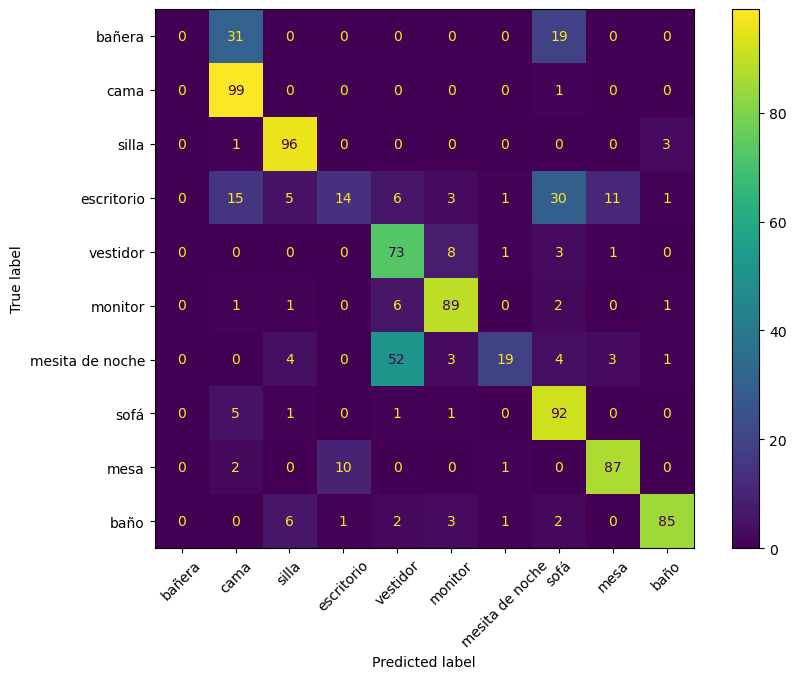

In [61]:
from sklearn.metrics import ConfusionMatrixDisplay
classNames = ['bañera','cama','silla','escritorio','vestidor','monitor','mesita de noche','sofá','mesa', 'baño']
cmp = ConfusionMatrixDisplay(cm, display_labels=classNames)
fig, ax = plt.subplots(figsize=(10,7))
cmp.plot(ax=ax)
ax.tick_params('x', labelrotation=45)

## Aspecto de las convoluciones de 1 objeto

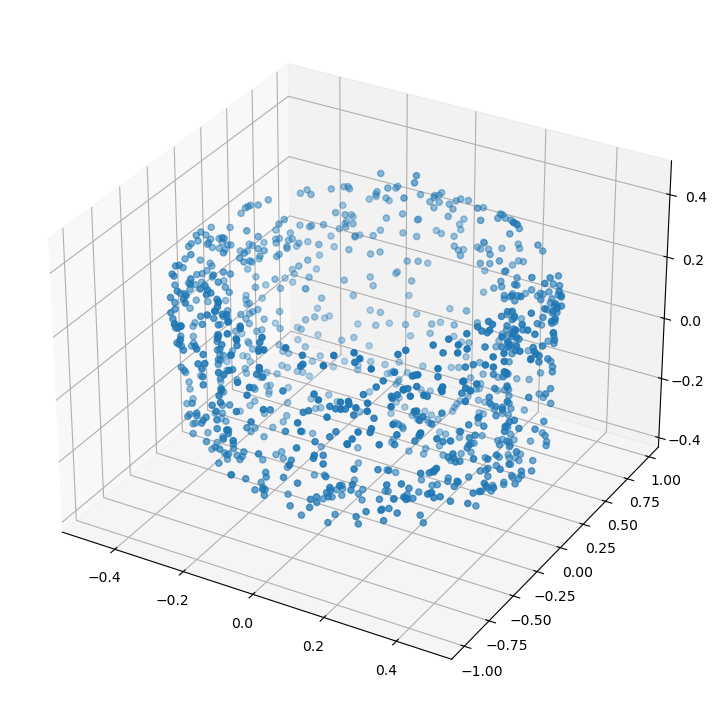

In [62]:
import matplotlib.pyplot as plt
data = next(iter(testloader))
inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
outputs, M3x3, M64x64 = model(inputs.transpose(1,2))
pcshow(*inputs[0].T)

torch.Size([64, 1024, 3]) torch.Size([64, 3, 3]) torch.Size([64, 1024, 3])


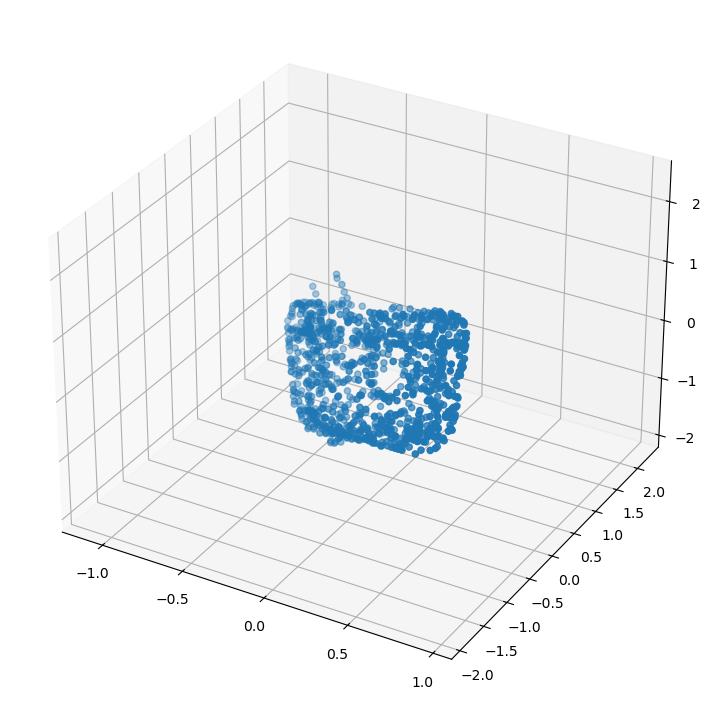

In [63]:
#model.transform.input_transform(inputs, 3) 
#xb = torch.bmm(torch.transpose(inputs,1,2), M3x3).transpose(1,2)
xb = torch.bmm(inputs, M3x3)
print(inputs.shape, M3x3.shape, xb.shape)
pcshow(*xb.detach().numpy()[0].T)

__La transformación afin anterior viene dada por la matriz__:

In [64]:
import sympy as sp
sp.Matrix(M3x3[0].detach().numpy())

Matrix([
[ 0.717575, 0.0269542, 0.508495],
[-0.984686,   1.90717,  -1.9247],
[-0.468806,    1.7097,  2.01447]])

## Procesamiento ficheros obtenidos con scanner LiDAR

In [65]:
nube_transforms = transforms.Compose([
                    Normalize(),
                    RandRotation_z(),
                    RandomNoise(),
                    ToTensor()
                    ])

In [66]:
import glob, os
my_directory = "/content/drive/My Drive/Colab Notebooks/split" if googleColaboratory else './data/lidarscan'
os.chdir(my_directory)
isFirst=True
for file in glob.glob("*.pts"):
    with open(file, 'r') as f:
        line = f.readline()
        miNube = []
        while line:
            line= f.readline()
            if line != "": 
                x,y,z,w,r,g,b=line.split()
                miNube.append([float(x), float(y), float(z)])
        tensorNube = nube_transforms(np.asarray(random.choices(miNube, k = 1024)))
        if isFirst:
            loteNubes = torch.unsqueeze(tensorNube.type(torch.FloatTensor), 0)
            isFirst = False
        else:
            tensorNube = torch.unsqueeze(tensorNube.type(torch.FloatTensor), 0)
            loteNubes = torch.cat((loteNubes, tensorNube), 0)
print("done!")

done!


In [67]:
loteNubes.shape

torch.Size([5, 1024, 3])

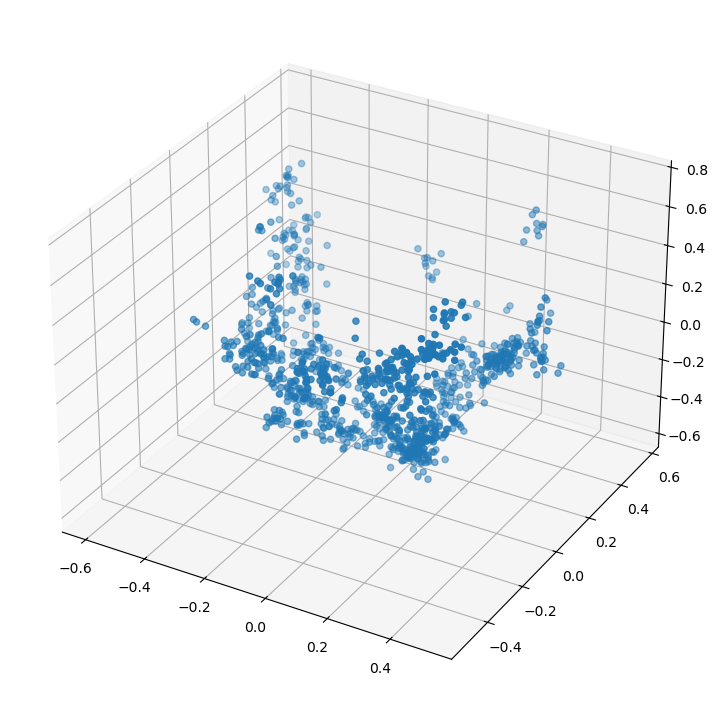

In [68]:
pcshow(*loteNubes[1].T)

### Se hace la predicción del lote

Es simplemente una prueba de concepto de como manejar los datos. El fichero usado es un volcado de un escaneo con LiDAR sobre una estructura leñosa de un árbol. Al no corresponderse con ninguno de los objetos del entrenamiento, la clasificación no es adecuada

In [69]:
outputs, A3, B64 = model(loteNubes.transpose(1,2))
_, predicted = torch.max(outputs.data, 1)

In [70]:
predicted

tensor([2, 9, 9, 9, 9])

In [71]:
"La predicción es = {}".format(list(classes)[predicted[0]])

'La predicción es = chair'